In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import json
import logging
from pathlib import Path

import polars as pl

from src.log_config import configure_logging
from src.models.data_loader import create_dataloaders
from src.models.data_preparation import (
    expand_feature_list,
    load_data_from_database,
    prepare_data,
)
from src.models.main_config import RANDOM_SEED
from src.models.utils import load_model
from src.plots.model_performance import (
    get_model_predictions,
    plot_multiple_pr_curves,
    plot_multiple_roc_curves,
    plot_single_roc_curve,
)

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "filelock"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials

polars.config.Config

In [3]:
feature_lists = [
    ["eda_raw", "pupil"],
    ["eda_raw", "heart_rate"],
    # ["eda_raw", "heart_rate", "pupil"],
    # ["face"],
    # ["eeg"],
]
feature_lists = expand_feature_list(feature_lists)
feature_list = feature_lists[0]
feature_list_str = "_".join(feature_list)

In [ ]:
results = {}
winning_models = {}

for feature_list in feature_lists:
    feature_list_str = "_".join(feature_list)
    # Load data from database
    df = load_data_from_database(feature_list=feature_list)

    # Load model
    json_path = Path(f"results/experiment_{feature_list_str}/results.json")
    dictionary = json.loads(json_path.read_text())
    model_path = Path(dictionary["overall_best"]["model_path"].replace("\\", "/"))

    model, feature_list, sample_duration_ms, intervals, label_mapping, offsets_ms = (
        load_model(model_path, device="cpu")
    )
    winning_models[feature_list_str] = {feature_list_str: model.__class__.__name__}

    # Prepare data
    X_train, y_train, X_val, y_val, X_train_val, y_train_val, X_test, y_test = (
        prepare_data(
            df=df,
            feature_list=feature_list,
            sample_duration_ms=sample_duration_ms,
            intervals=intervals,
            label_mapping=label_mapping,
            offsets_ms=offsets_ms,
            random_seed=RANDOM_SEED,
        )
    )
    test_groups = prepare_data(
        df=df,
        feature_list=feature_list,
        sample_duration_ms=sample_duration_ms,
        intervals=intervals,
        label_mapping=label_mapping,
        offsets_ms=offsets_ms,
        random_seed=RANDOM_SEED,
        only_return_test_groups=True,
    )
    _, test_loader = create_dataloaders(
        X_train_val, y_train_val, X_test, y_test, batch_size=64
    )
    probs, y_true = get_model_predictions(
        model,
        test_loader,
    )
    results[feature_list_str] = (probs, y_true)

18:03:48 | INFO    | utils | Using device: cpu
18:03:48 | INFO    | utils | Loaded PatchTST model with test accuracy 0.76 to cpu
18:03:48 | INFO    | utils | Input shape: (70, 2) | Features: ['eda_raw', 'pupil'] | Sample duration: 7000 ms
18:03:48 | DEBUG   | utils | Intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
18:03:48 | DEBUG   | utils | Label mapping: {'increases': 0, 'plateaus': 0, 'decreases': 1}
18:03:48 | DEBUG   | utils | Offset ms: {'increases': 0, 'plateaus': 5000, 'decreases': 1000}
18:03:49 | DEBUG   | sample_creation | Removed 749 samples with less than 69 data points
18:03:49 | DEBUG   | data_preparation | Preparing data with sample duration 7000 ms and random seed 42
18:03:49 | DEBUG   | data_preparation | Samples are based on intervals: {'increases': 'strictly_increasing_intervals', 'plateaus': 'plateau_intervals', 'decreases': 'major_decreasing_intervals'}
18:03:49 | DEBUG   | data

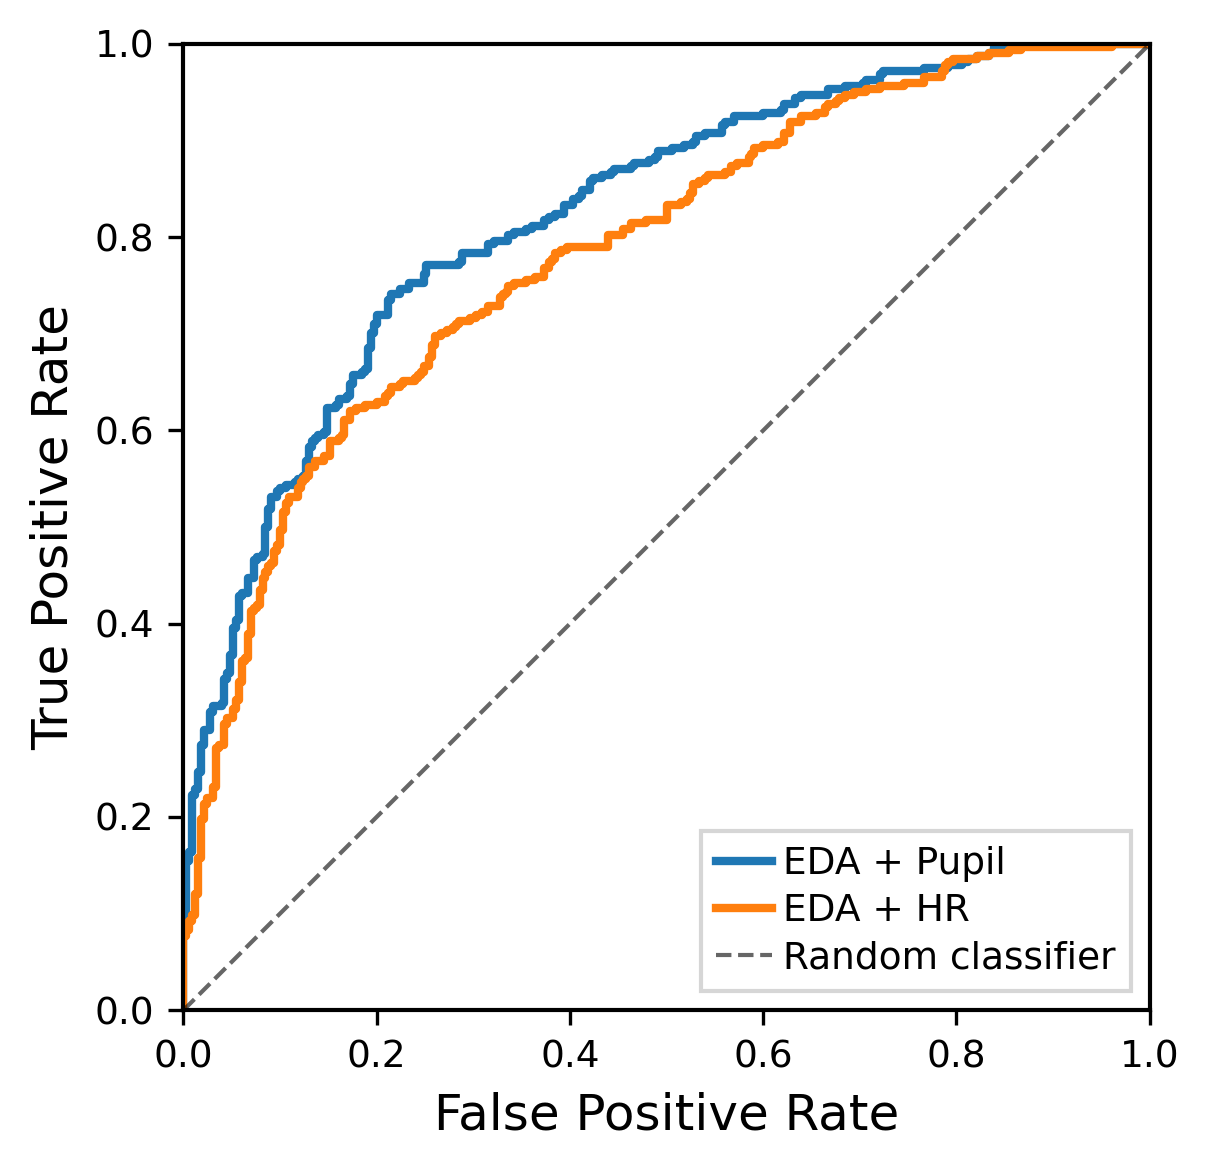

In [7]:
roc_curves = plot_multiple_roc_curves(results)


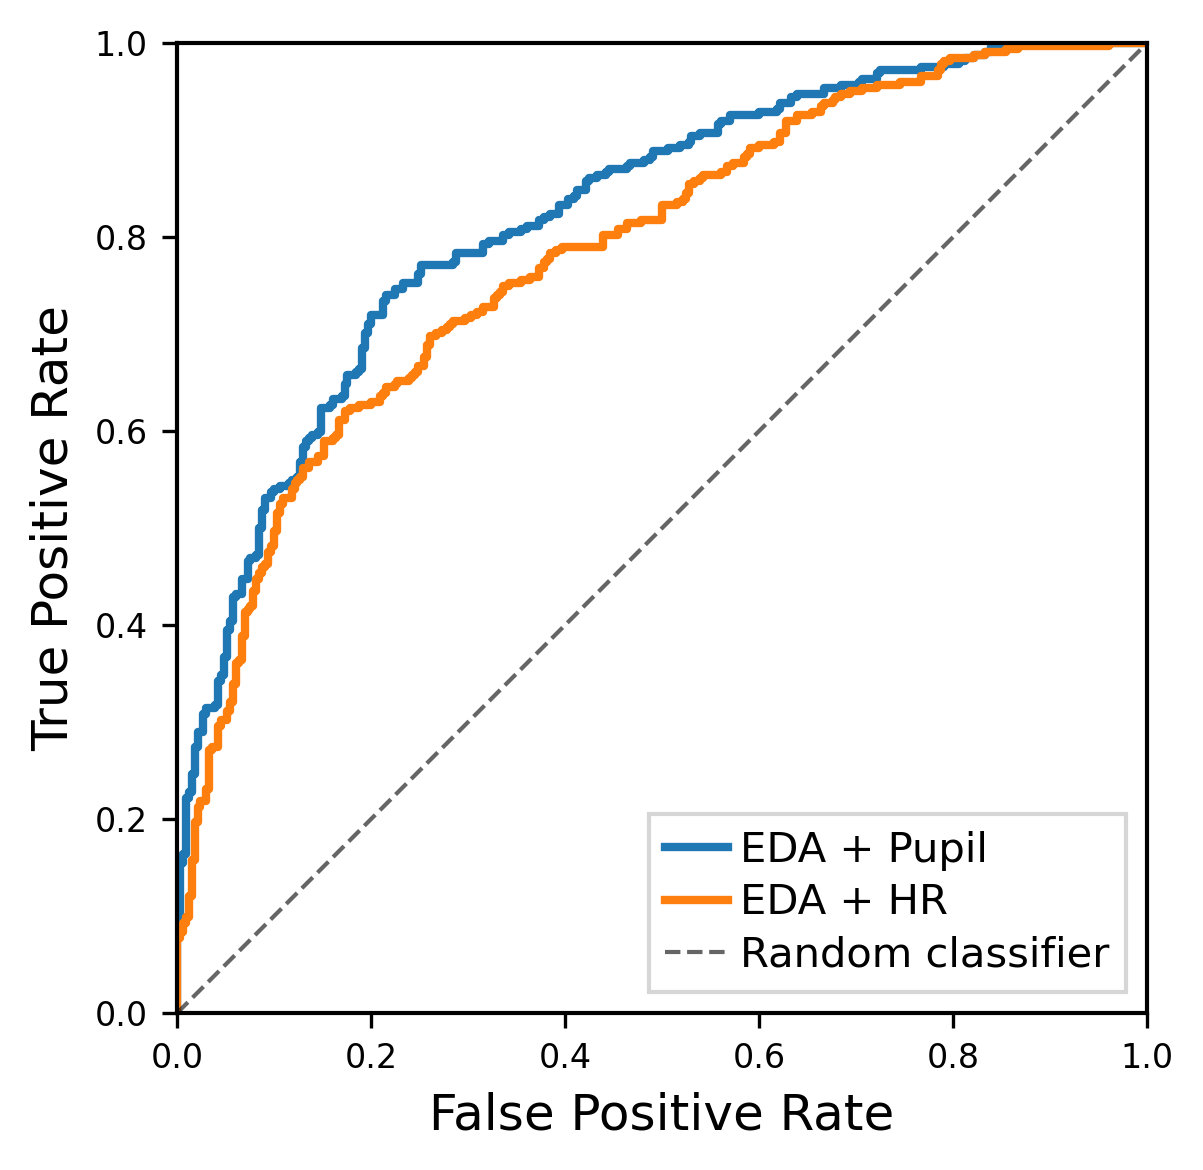

In [5]:
roc_curves = plot_multiple_roc_curves(results)


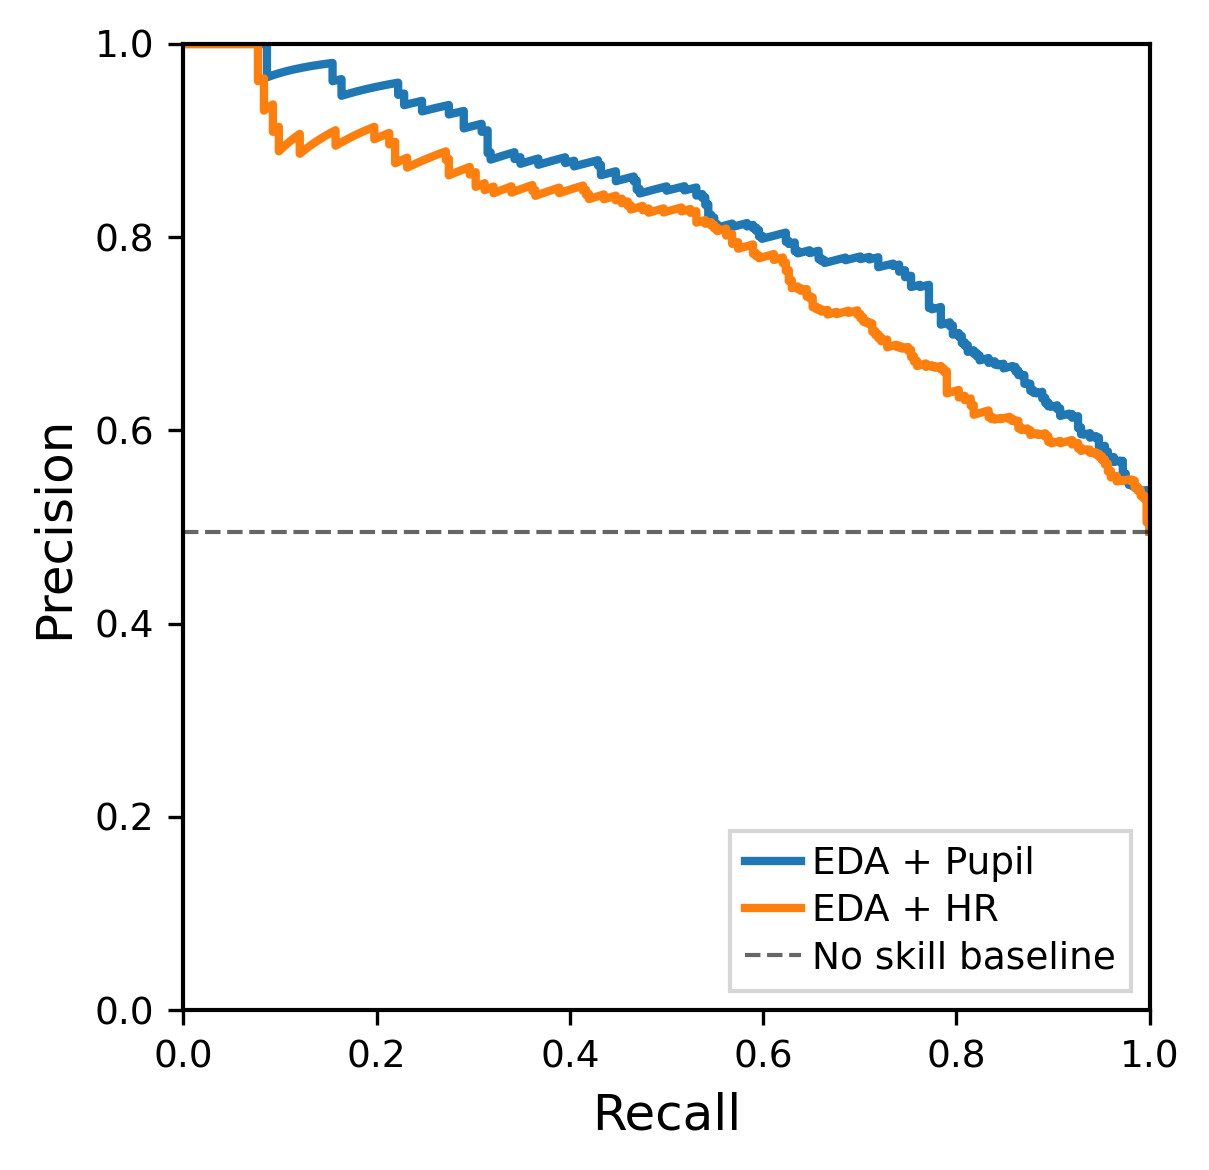

In [6]:
pr_curves = plot_multiple_pr_curves(results)


In [23]:
single_roc_curve = plot_single_roc_curve(results["eda_raw"][0], results["eda_raw"][1])

KeyError: 'eda_raw'

In [ ]:
probs, y_true = get_model_predictions(
    model,
    test_loader,
)

/Users/visser/drive/PhD/Code/pain-measurement/src/plots/model_performance.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  conf_matrix_plot.show()
/Users/visser/drive/PhD/Code/pain-measurement/src/plots/model_performance.py:82: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  conf_matrix_plot.show()


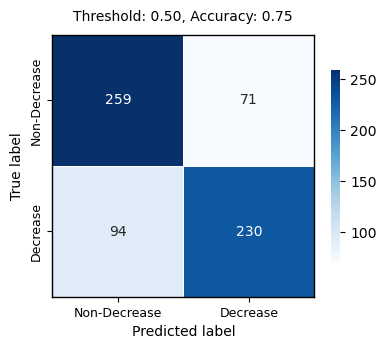

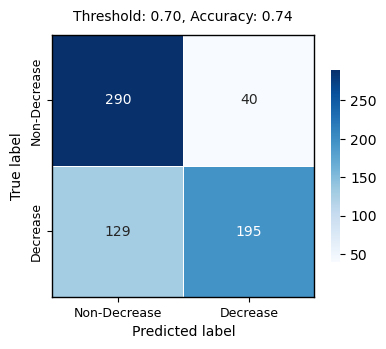

In [ ]:
conf_matrix_05 = get_confusion_matrix(probs, y_true, threshold=0.5)
conf_matrix_08 = get_confusion_matrix(probs, y_true, threshold=0.7)

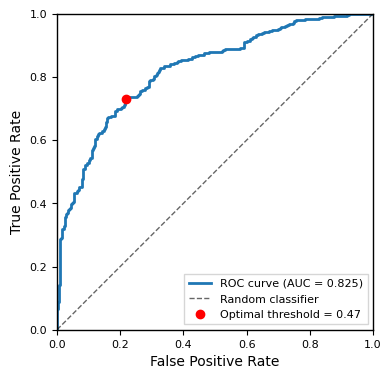

In [ ]:
single_roc_curve = plot_single_roc_curve(probs, y_true)

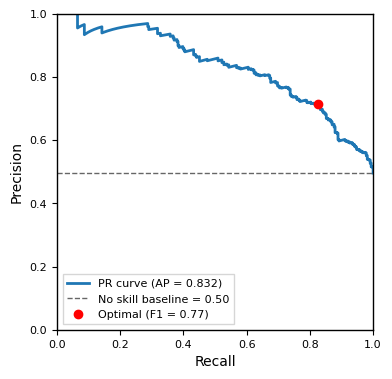

In [ ]:
single_pr_curve = plot_single_pr_curve(probs, y_true)  # ap = average precision